# Input Representations

In [1]:
import numpy as np
import librosa
import matplotlib.pyplot as plt
import IPython.display as ipd
import librosa.display

print(f"{librosa.__version__=}")

librosa.__version__='0.8.1'


In [2]:
SR = 22050
wide = (18, 3)  # figure size

In [60]:
src, sr = librosa.load('are-you-here-with-me(mono).mp3', sr=SR, mono=True, duration=5.0)
assert sr == SR
print(src.shape)

/Users/admin/miniconda3/lib/python3.8/site-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


(110250,)


# Waveforms

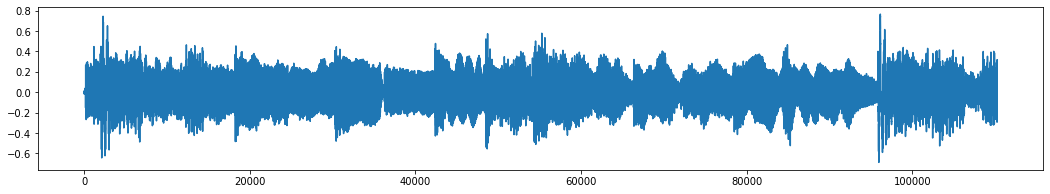

In [61]:
plt.figure(figsize=wide)
plt.plot(src)

In [62]:
ipd.Audio(src, rate=sr) # load a NumPy array

In [63]:
# from librosa.display import waveshow

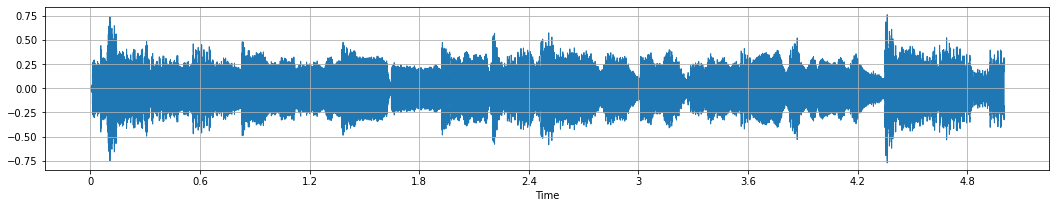

In [64]:
plt.figure(figsize=wide)
librosa.display.waveshow(src, sr=22050)
plt.grid(True)

(-0.5, 0.5)

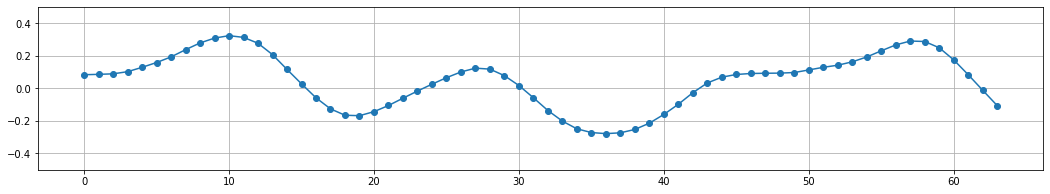

In [66]:
plt.figure(figsize=wide)
plt.plot(src[20400:20464], marker='o' )
plt.grid(True)
plt.ylim([-0.5, 0.5])

Waveforms are records of amplitudess of audio. This 5-second 22,050-Hz sampled mono audio has a shape of `(110250, )`. 

- They are representations for (diaphragms of) speakers, whose goal is to produce the sound correctly.
- Is waveform the best representation of our auditory systems? Probably not. The amplitudes are what our eardrums respond to. But the signal is, then, converted to something like 2-dimensional representation in our cochlear. I.e., we do some sort of frequency analysis in our auditory system. 

In other words, 2-dimensioal representations are biologically plausible. Also,

- Is waveform the best representation for neural networks? Well, it may or may not be. So far, for analysis purposes, it's okay -- not quite the best most of the time. 
- In practice, spectrograms have been a very strong and neural network-friendly representation.


# Spectrograms: time-frequency representations

Spectrogram refers to a (2D) visualization of sound. Let's take a look at STFT first.

## STFT

STFT (short-time Fourier transform) is the most "raw" kind of spectrograms
  - We can fully reconstruct the audio signal from a STFT. 
  - It has a linear frequency resolution spans from 0 Hz (DC component) to (sample rate) / 2 Hz (aka Nyquist frequency). 
  - STFT consists of complex numbers.
    - **Modification 1**: However, for analysis purposes, we usually use its magnitudes. This is biologically plausible since [the human auditory system is insensitive to phase information].(https://ptolemy.berkeley.edu/eecs20/week8/phase.html).
    
In papers and such, STFT usually refers to the magnitude of STFT while the original, complex-numbered STFT is referred as "complex STFT" or something like that.

stft_complex.dtype=dtype('complex64')
stft_complex.shape=(257, 862)
stft_complex[3, 3]=(-0.9134862+0.22103079j)

stft.dtype=dtype('float32')
stft.shape=(257, 862)
stft[3, 3]=0.9398466



Text(0.5, 1.0, 'Manitude spectrogram (abs(STFT))')

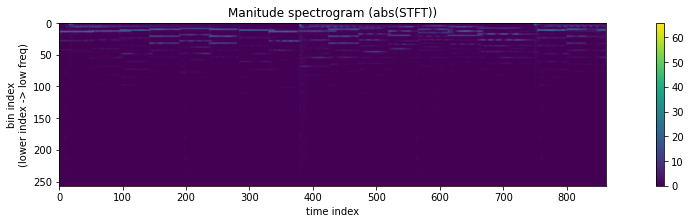

In [77]:
n_fft = 512
hop_length = n_fft // 4
stft_complex = librosa.stft(y=src, n_fft=n_fft, hop_length=hop_length)
print(f"{stft_complex.dtype=}\n{stft_complex.shape=}\n{stft_complex[3, 3]=}\n")

stft = np.abs(stft_complex)
print(f"{stft.dtype=}\n{stft.shape=}\n{stft[3, 3]=}\n")

plt.figure(figsize=wide)
img = plt.imshow(stft)
plt.colorbar(img)
plt.ylabel('bin index\n(lower index -> low freq)');plt.xlabel('time index')
plt.title('Manitude spectrogram (abs(STFT))')

Can you see the slight activations on the lower frequency (near the upper boundary)? That's the magnitudes of the STFT of our example signal. 

Let's time-average the frequency distribution and plot it.

Text(0.5, 1.0, 'Frequency magnitude (linear scale)')

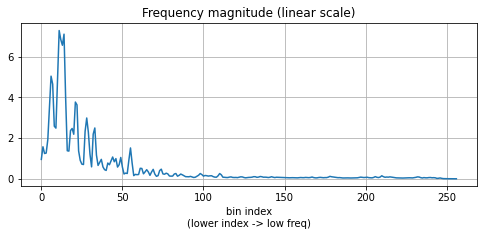

In [68]:
stft_freq_distritubion = np.mean(stft, axis=1)
plt.figure(figsize=wide)
plt.subplot(1, 2, 1)
plt.plot(stft_freq_distritubion)
plt.xlabel('bin index\n(lower index -> low freq)')
plt.grid(True)
plt.title('Frequency magnitude (linear scale)')

This is quite a long-tail, and that's why the spectrogram above was not very clear for us. 
And even worse, this kind of extreme distribution is not good for neural networks. 

That's why we usually take `log()` to magnitude spectrograms. Let's first compare their distributions.

- **Modification 2** After `abs()`, we compress it with `log()`. This is also biologically plausible - human perception is loudness is much closer to the logarithm scale than a linear scale (i.e., it follows Weber–Fechner law)
  

(You can find more discussion on this in [**[CFC+2018a]**](https://arxiv.org/abs/1709.01922).)

Text(0.5, 1.0, 'Frequency magnitude (log scale)')

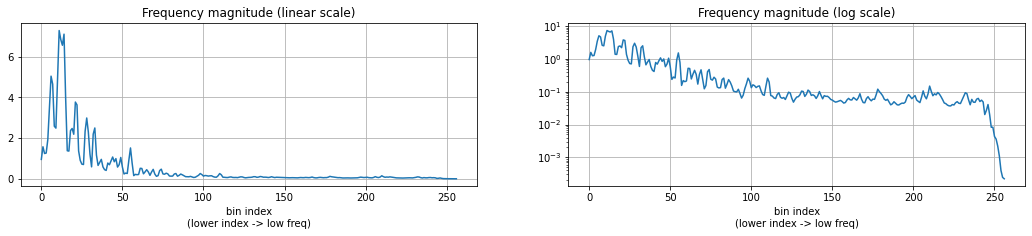

In [69]:
stft_freq_distritubion = np.mean(stft, axis=1)
plt.figure(figsize=wide)
plt.subplot(1, 2, 1)
plt.plot(stft_freq_distritubion)
plt.xlabel('bin index\n(lower index -> low freq)')
plt.grid(True)
plt.title('Frequency magnitude (linear scale)')

plt.subplot(1, 2, 2)
plt.semilogy(stft_freq_distritubion)
plt.xlabel('bin index\n(lower index -> low freq)')
plt.grid(True)
plt.title('Frequency magnitude (log scale)')

If this is not super clear to you, let me show the spectrogram with logarithm compression.

Listen to the song again! 🥁

log_stft.dtype=dtype('float32')
log_stft.shape=(257, 862)
log_stft[3, 3]=-0.060975205



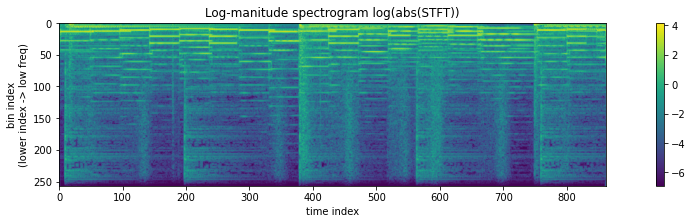

In [76]:
epsilon = 0.001
log_stft = np.log(np.abs(stft_complex) + epsilon)
print(f"{log_stft.dtype=}\n{log_stft.shape=}\n{log_stft[3, 3]=}\n")

plt.figure(figsize=wide)
img = plt.imshow(log_stft)
plt.colorbar(img)
plt.ylabel('bin index\n(lower index -> low freq)');plt.xlabel('time index')
plt.title('Log-manitude spectrogram log(abs(STFT))')

ipd.Audio(src, rate=sr) # load a NumPy array

The essence of this logarithm mapping (or compression) of magnitudes is to use the nonlinear curve of `log(x)` where `x > 1`. This is exactly what's happening in [Decibel scaling](https://en.wikipedia.org/wiki/Decibel). Decibel scaling is also logarithm mapping but with a few different choices of the constants (e.g., log10 vs log, etc) so that 0 dB becomes absolute silence and 130 dB becomes a really really loud sound. Check out the implementations in [`librosa.amplitude_to_db()`](https://librosa.org/doc/main/generated/librosa.amplitude_to_db.html) and [`librosa.power_to_db()`](https://librosa.org/doc/main/generated/librosa.power_to_db.html) for more correct and  numerically stable and decibel scaling.

Finally, it doesn't look so right when low-frequency is at the top of the image. 

log_stft.dtype=dtype('float32')
log_stft.shape=(257, 862)
log_stft[3, 3]=-6.8234167



Text(0.5, 1.0, 'Log-manitude spectrogram log(abs(STFT))')

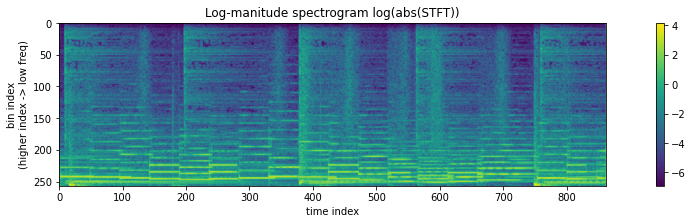

In [75]:
epsilon = 0.001
log_stft = np.log(np.abs(stft_complex) + epsilon)
log_stft = np.flipud(log_stft)  # <-- Here!
print(f"{log_stft.dtype=}\n{log_stft.shape=}\n{log_stft[3, 3]=}\n")

plt.figure(figsize=wide)
img = plt.imshow(log_stft)
plt.colorbar(img)
plt.ylabel('bin index\n(higher index -> low freq)');plt.xlabel('time index')
plt.title('Log-manitude spectrogram log(abs(STFT))')


From here, I'll use `libros` more actively because i) the implementation of other representations is not trivial and ii) so that the x- and y-axes are nicely displayed in more convenient units.

Additionally, it's always safe to make your data zero-centered. That's also done quite nicely with the default parameters of `librosa`. 

Text(0.5, 1.0, 'log-STFT, i.e., log(abs(stft))')

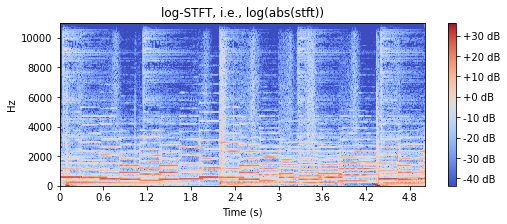

In [72]:
plt.figure(figsize=wide)
plt.subplot(1, 2, 1)
img = librosa.display.specshow(librosa.amplitude_to_db(stft), sr=SR, x_axis='s', y_axis='linear', hop_length=hop_length)
plt.colorbar(img, format="%+2.f dB")
plt.title('log-STFT, i.e., log(abs(stft))')

## Even more modifications? 

By computing log(abs(STFT)), we get a nice image of the sound. But, it is just a beginning! 


### Reasons for modifying the frequency scale
 - Our perception of frequency is also nonlinear (approximately.. (drum rolls!..) logarithmic).
 - Similarly, we defined pitches in the octave (=logarithmic) scale

### Reasons why it's okay to remove some high frequency bands
 - The highest frequency of original audio signals is usually 22kHz which is pretty far beyond our range. 
 - Similarly, the information in high-frequency ranges (e.g., f > 10kHz) is i) sparse, ii) not that necessary for most of MIR tasks, and iii) barely audible for us.

### Reason why, then, it's better to remove some high frequency bands
 - Because we want to remove any redundant memory and computation especially in deep leanring.


Because of these, researchers have been using time-frequency representations that are modifications of log(abs(STFT)). 

### Melspectrograms

Melspectrograms have been the top choices for music tagging and classification. But what is a melspectrogram?

Melspectrogram is a result of converting the linear frequency scale into the *mel scale*. There are many similar but different formula to compute it, but it's *kinda like* log-scale. 

**Benefits**
- It's reduces the number of frequency band greatly. For example, 1028 -> 128. What a deep learning-plausible number it becomes!
- It's simple and fast - the computation is a matrix multiplication of a pre-computed filterbank matrix.
- It's effective - the model works even better in many cases.

In [73]:
log_melgram = librosa.power_to_db(
    np.abs(
        librosa.feature.melspectrogram(src, sr=SR, n_fft=n_fft, hop_length=hop_length, power=2.0)
    )
)

Text(0.5, 1.0, 'log(melspectrogram)')

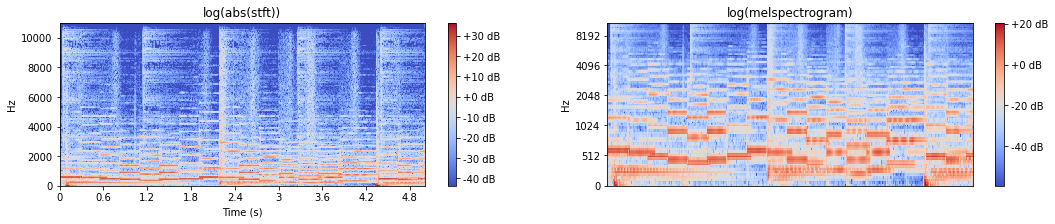

In [74]:
plt.figure(figsize=wide)
plt.subplot(1, 2, 1)
img = librosa.display.specshow(librosa.amplitude_to_db(stft), sr=SR, x_axis='s', y_axis='linear', hop_length=hop_length)
plt.colorbar(img, format="%+2.f dB")
plt.title('log(abs(stft))')

plt.subplot(1, 2, 2)
img = librosa.display.specshow(log_melgram, y_axis='mel', sr=SR, hop_length=hop_length)
plt.colorbar(img, format="%+2.f dB")
plt.title('log(melspectrogram)')

<!-- Comparing the two axes, it is clear that low-frequency ranges conveys a lot of music information. By allocating a lot of bins to the low-frequency range, in the melspectrogram, the -->

### Constant-Q Transform

As we've seen, melspectrograms are great! But it is just a simple aggregation of high-frequency bins into one. This means the frequency resolution of melspectrogram is bound by that of STFT. And there is always a trade-off between time and frequency resolutions in STFT. 

Constant-Q Transform is more radical. Why not having accurately octave scale representation? 

Its implementation is not trivial, but the idea is to use time-varying windows for different center frequency. Let's see the result.

In [150]:
log_cqt = librosa.amplitude_to_db(
    np.abs(
        librosa.cqt(src, sr=SR, hop_length=hop_length, n_bins=24*7, bins_per_octave=24, fmin=librosa.note_to_hz('C1'))
    )
)

Text(0.5, 1.0, 'log(cqt)')

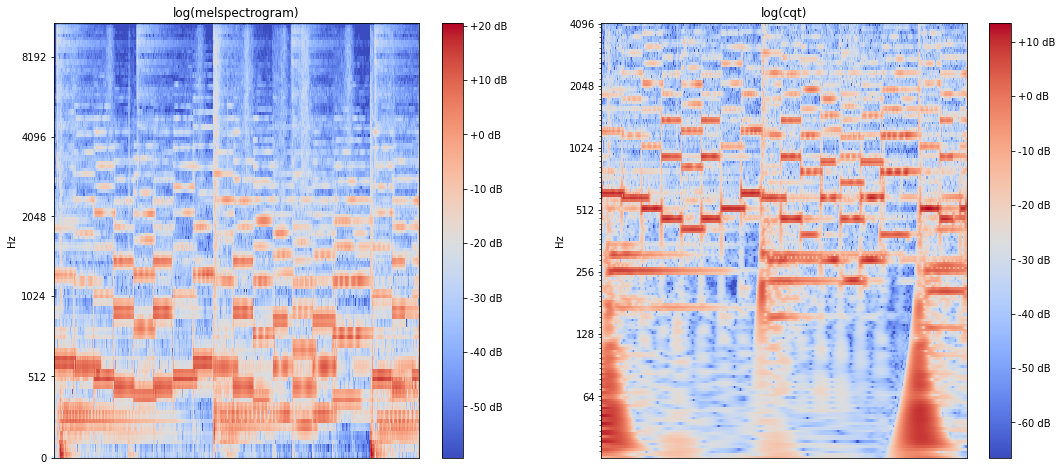

In [151]:
plt.figure(figsize=(18, 8))
plt.subplot(1, 2, 1)
img = librosa.display.specshow(log_melgram, y_axis='mel', sr=SR, hop_length=hop_length)
plt.colorbar(img, format="%+2.f dB")
plt.title('log(melspectrogram)')

plt.subplot(1, 2, 2)
img = librosa.display.specshow(log_cqt, y_axis='cqt_hz', sr=SR, hop_length=hop_length, bins_per_octave=24)
plt.colorbar(img, format="%+2.f dB")
plt.title('log(cqt)')

The difference is pretty obvious here - we get a much better pitch resolution!

### Train your own filterbank


1. Get back to sample-based models?
2. STFT-based filterbanks - hmm..